In [1]:
import psycopg2 as pg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

# Create dabatase 'bank'

In [ ]:
secret = 'password'
conn = pg2.connect(user='postgres', password=secret)

In [ ]:
conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)

In [ ]:
cursor = conn.cursor()
nameDB = 'bank'
createDB_string = 'CREATE DATABASE ' + nameDB 

In [ ]:
cursor.execute(createDB_string)

# Work with 'bank' database

In [2]:
databaseName = 'bank'
secret = 'password'
conn = pg2.connect(database = databaseName, user = 'postgres', password = secret)
cursor = conn.cursor()

# Create table

Code to create a SQL table

In [ ]:
cursor.execute(
"""CREATE TABLE bank(
age int, job VARCHAR(50),marital VARCHAR(50),
education VARCHAR(50), default_value VARCHAR(50), 
balance int, housing VARCHAR(50),
loan VARCHAR(50), contact VARCHAR(50),
day int, month VARCHAR(50),
duration int, campaign int,
pdays int,
previous int, poutcome VARCHAR(50),
deposit VARCHAR(50)
);""")b


### Reas CSV files


In [3]:
import pandas as pd
from sqlalchemy import create_engine
bank = pd.read_csv('bank.csv')

In [11]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


### Create a table in PostgreSQL

A specific process had to be followed to create a database without it existing of PostgreSQL

In [ ]:
def engine_sql():
    user = 'postgres'
    password = 'password'
    host = '127.0.0.1'
    port = 5432
    database = 'bank'
    return create_engine(url=f"postgresql://{user}:{password}@{host}:{port}/{database}")

In [4]:
bank.to_sql('bank', engine_sql(), if_exists='replace', index = False)

NameError: name 'engine_sql' is not defined

In [5]:
bank.shape

(11162, 17)

In [6]:
cursor.execute('SELECT * FROM bank')

In [8]:
cursor.execute('SELECT * FROM bank')
cursor.fetchone()

(59,
 'admin.',
 'married',
 'secondary',
 'no',
 2343,
 'yes',
 'no',
 'unknown',
 5,
 'may',
 1042,
 1,
 -1,
 0,
 'unknown',
 'yes')

## Questions

* Which professions are the most popular among customers over 45 years old?
* For how many people with loans did the marketing campaign succeed?
* Does the success depend on the balance, deposit, or loan?

## First question

* Which professions are the most popular among customers over 45 years old?

In [8]:
# Function to send cursor to beggining of the query
def cursor_to_beggining(cursor):
    cursor.scroll(0,mode='absolute')
    return cursor

In [9]:
query_first_question = '''SELECT job, COUNT(*) FROM bank
                            WHERE age > 45
                            GROUP BY job
                            ORDER BY COUNT(*) DESC;
                            '''
cursor.execute(query_first_question)
data_first_question = cursor.fetchall()
data_first_question

[('retired', 764),
 ('management', 757),
 ('blue-collar', 537),
 ('technician', 456),
 ('admin.', 361),
 ('services', 206),
 ('housemaid', 157),
 ('entrepreneur', 125),
 ('unemployed', 118),
 ('self-employed', 113),
 ('unknown', 37),
 ('student', 2)]

In [10]:
query_first_question_2 = '''SELECT job, COUNT(*) FROM bank
                            GROUP BY job
                            ORDER BY COUNT(*) DESC'''
cursor.execute(query_first_question_2)
data_first_question_2 = cursor.fetchall()

In [11]:
data_first_question[1][1]/data_first_question_2[0][1]

0.29501169134840216

### Answer 1

The most popular profession, aside from retired, is management. One third of the overall workes who are at a management position belong to a population of age greater than 45

## Second question

* For how many people with loans did the marketing campaign succeed?

In [12]:
query_second_question = '''SELECT COUNT(*) FROM bank
                            WHERE loan=\'yes\' AND poutcome= \'success\''''

cursor.execute(query_second_question)
cursor.fetchall()[0][0]

51

## Third question question

* Does the success depend on the balance, deposit, or loan?

In [13]:
# We are going to see which where the number of success increases first!
query_third_question_1 = '''
SELECT deposit, COUNT(*) FROM bank
WHERE poutcome = \'success\'
GROUP BY deposit
'''

cursor.execute(query_third_question_1)
cursor.fetchall()

[('no', 93), ('yes', 978)]

## Deposit
* 8.6% of people in which the campaign was a success did not receive loans
* The campaign was a succes in almost of people that received loans (91.3% approximately)

In [14]:
query_third_question_2 = '''
SELECT loan, COUNT(*) FROM bank
WHERE poutcome = \'success\'
GROUP BY loan
'''

cursor.execute(query_third_question_2)
cursor.fetchall()

[('no', 1020), ('yes', 51)]

## Loan
* 95.23% people in which the campaign was a success did not receive loans
* The campaign was a succes for 4.7% of people that received loans

In [15]:
# Obtain mean to have threshold on what can affect the success of the campign
query_third_question_3='''
SELECT SUM(balance)/COUNT(*) FROM bank
'''
cursor.execute(query_third_question_3)
cursor.fetchall()[0][0]

Decimal('1528.5385235620856477')

In [16]:
# We now know what the mean is
mean_balance = 1528.5385
query_third_question_3='''
SELECT COUNT(*) FROM bank
WHERE balance > 1528.5385 AND poutcome = \'success\'
'''

cursor.execute(query_third_question_3)
cursor.fetchall()

[(378,)]

## Problem

I cannot come up with a good solution to see if balance does affect whether the campaign is successful or not with SQL. I'll be using python to plot how the relationship is between these two variables 

In [17]:
query_data_balance = '''
SELECT balance FROM bank
WHERE poutcome= \'success\'
'''

cursor.execute(query_data_balance)
data_balance = cursor.fetchall()

In [18]:
# Now we have the information in the variable 'data_valance', let's explore what it tells us
print(type(data_balance))

# Since it is a list, we must convert it to a dataframe for better understanding


<class 'list'>


In [19]:
data_balance_df = pd.DataFrame(data_balance, columns=['Balance'])

In [20]:
data_balance_df

,Balance
0,589
1,2269
2,3354
3,3352
4,1331
...,...
1066,0
1067,348
1068,145
1069,658


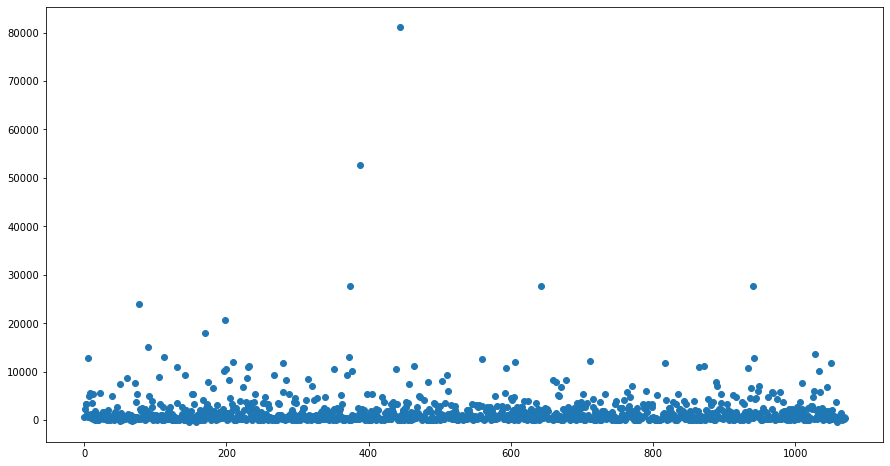

In [26]:
# We must import the library for plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.scatter(x=data_balance_df.index,y=data_balance_df.Balance)

There are various outliers that must be eliminated to obtain a better picture of the marketing campaign

In [27]:
data_balance_df.describe()

,Balance
count,1071.000000
mean,1980.014006
std,4099.156602
min,-382.000000
25%,274.000000
50%,867.000000
75%,2239.500000
max,81204.000000


From this picture we can see that the std is very high when compared with the 25%, 50% and 75% percentile. Thus the outliers are very high, we can try with 3000 so that a threshold is set and see how much data lies within these boundaries

In [28]:
data_balance_df[data_balance_df.Balance <=3000].shape[0]/data_balance_df.shape[0]

0.8216619981325863

82% of the information is captured with a threshold of 3000, we will set this higher so that at least 90% is captured

In [29]:
data_balance_df[data_balance_df.Balance <=5000].shape[0]/data_balance_df.shape[0]

0.9094304388422035

With a threshold of 5000 90% of information is captured but is almost double of the 75% percentile, so maybe we'll set the threshold to 85% of data captured

In [30]:
data_balance_df[data_balance_df.Balance <=3500].shape[0]/data_balance_df.shape[0]

0.8524743230625583

With this, 85% of information is captured, let's plot it again

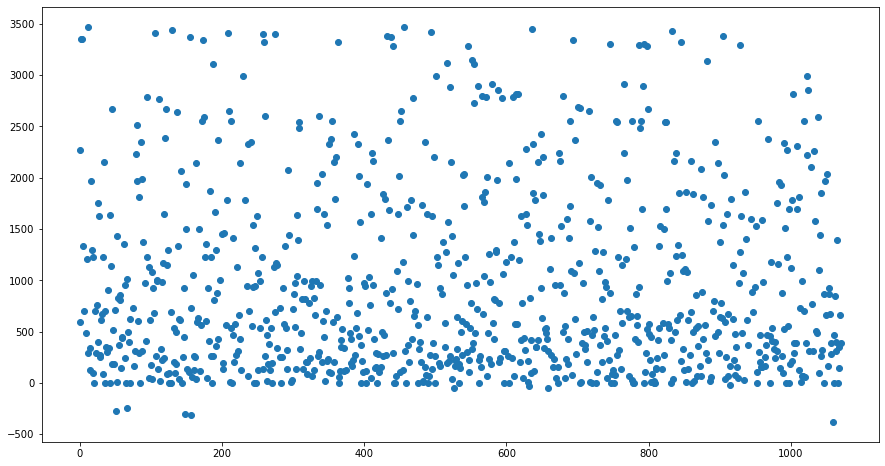

In [31]:
data_balance_df_threshold = data_balance_df[data_balance_df.Balance <=3500]

plt.figure(figsize=(15,8))
plt.scatter(x=data_balance_df_threshold.index,y=data_balance_df_threshold.Balance)

We will be organizing the information to have a better picture

In [32]:
data_balance_df_threshold = data_balance_df_threshold.sort_values(by='Balance')
data_balance_df_threshold.shape

(913, 1)

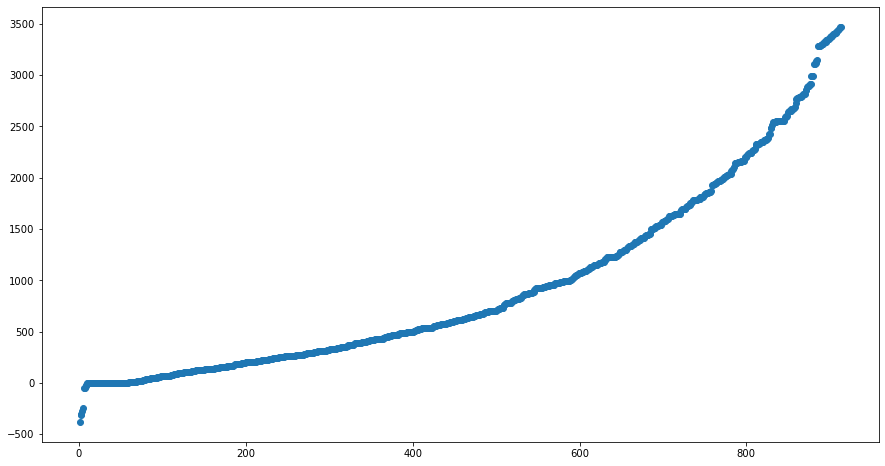

In [21]:
plt.figure(figsize=(15,8))
plt.scatter(x=range(1,914),y=data_balance_df_threshold.Balance)

Since there is no aparent tendency on the balance of the people for whose the marketing campaign was successful, let's see the same graph but comparing also for the people for which is was not successful

In [34]:
query_third_question_3_1 ='''
SELECT balance FROM bank
WHERE poutcome = \'failure\'
'''

cursor.execute(query_third_question_3_1)
data_balance_failure = cursor.fetchall()
data_balance_failure=pd.DataFrame(data_balance_failure, columns=['balance_failure'])

In [35]:
data_balance_failure.describe()

,balance_failure
count,1228.000000
mean,1544.090391
std,2521.696591
min,-1137.000000
25%,182.500000
50%,646.500000
75%,1963.250000
max,27696.000000


There are some differences regarding the min values in between the people for which it succeded and the people for which it did not, but let's graph both!

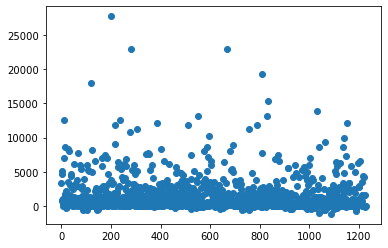

In [36]:
# Let's graph and detect outliers  the outliers
plt.scatter(data_balance_failure.index, data_balance_failure.balance_failure)

In [37]:
# Let's retain at least 85% of data to eliminate outliers
total_number_failures = data_balance_failure.shape[0]
data_balance_failure[data_balance_failure.balance_failure<=3000].shape[0]/total_number_failures

0.8558631921824105

In [38]:
data_balance_failure_threshold = data_balance_failure[data_balance_failure.balance_failure<=3000]
data_balance_failure_threshold.shape

(1051, 1)

In [39]:
data_balance_failure_threshold=data_balance_failure_threshold.sort_values(by='balance_failure')
data_balance_failure_threshold

,balance_failure
1089,-1137
1039,-938
1190,-663
729,-581
105,-556
...,...
444,2979
303,2986
596,2987
337,2987


In [40]:
# Let's see the number of cases for success and failure
size_failure = data_balance_failure_threshold.shape[0]
size_success = data_balance_df_threshold.shape[0]

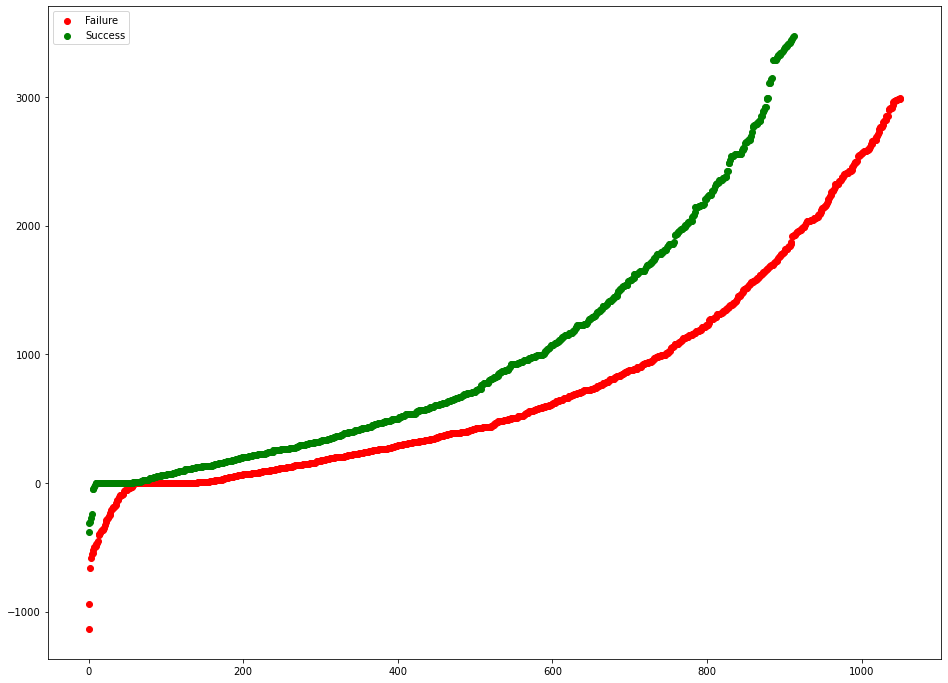

In [41]:
x_failure = range(size_failure)
x_success = range(size_success)
fig = plt.figure(figsize = (16,12))
plt.scatter(x=x_failure,y=data_balance_failure_threshold.balance_failure,c='red',label='Failure')
plt.scatter(x=x_success,y=data_balance_df_threshold.Balance,c='green',label='Success')
plt.legend(loc='upper left')
plt.show()

There is an obvious trend for both cases, failure and success. So let's do one more plot to show ALL the values for both cases, without the threshold.

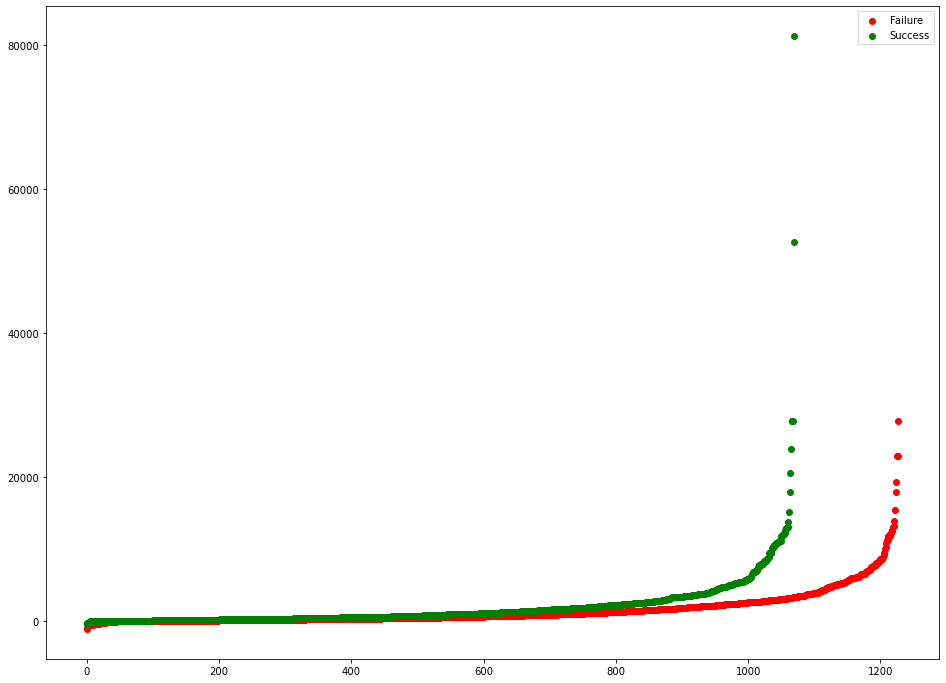

In [42]:
x_success_total = range(data_balance_df.shape[0])
x_failure_total = range(data_balance_failure.shape[0])
fig = plt.figure(figsize = (16,12))

plt.scatter(x=x_failure_total,y=data_balance_failure.sort_values(by='balance_failure').balance_failure,c='red',label='Failure')
plt.scatter(x=x_success_total,y=data_balance_df.sort_values(by='Balance').Balance,c='green',label='Success')

plt.legend(loc='upper right')
plt.show()

As a next step, a model to classify whether a campaign will be successful or not will be created based on these 3 parameters (for the sake of the project):
* Balance
* Deposit
* Loan

As a general process for the problem, we will:

### Knowledge and statement of the solution
1) See which classification techniques are available that can be implemented to this scenario


### Data cleansinng and filtering
1) Obtain a DataFrame in which these variables are isolated.

2) Eliminate innecesarry rows


### Pre-processing of information
2) Obtain dummy variables to the necessary columns

### Model
1) Identify the libraries to use

2) Statement of the parameters

3) Coding of the model

4) Evalauation of the results

5) Iteration of the model

6) Identification of the final model


### Data visualization
1) Visualization of the results of the model

# Statement of the solution
There are various ML techniques that can be applied for classification purposes. Supervised leraning techniques will be applied since we DO know the outcome of the campaign and it will yield results more suitable for our case. Various algorithms were investigated amongs which three were selected. This was due to having worked with them in the past, so we are familiar with how they work and their technical details:

1) Logistic Regression

2) K-nearest neighbour

3) Decision three

They will be implemented to see which one suits better the task of predicting the outcome of a bank's marketing campaing.

# Data cleansinng and filtering

In [43]:
# First of all, based on the data we have in the two variables afore used we will create our pandas DataFrame
# The reason why this data i used is that the outliers are already our of the equation and we DO know that at least 85% of the
# failure and success cases are there


# First we will assign the label 'success' of 'failure' to the DF
data_balance_failure_threshold['label'] = 'Failure'
data_balance_df_threshold['label'] = 'Success'

In [44]:
# Check the new DF
data_balance_failure_threshold.head()
data_balance_df_threshold.head()

,Balance,label
1059,-382,Success
157,-309,Success
148,-306,Success
51,-271,Success
67,-242,Success


In [45]:
# Let's combine both DF

data_balance_failure_threshold.columns = ['Balance', 'Label']
data_balance_df_threshold.columns = ['Balance', 'Label']

In [46]:
data_classification = pd.concat([data_balance_df_threshold,data_balance_failure_threshold])
data_classification

,Balance,Label
1059,-382,Success
157,-309,Success
148,-306,Success
51,-271,Success
67,-242,Success
...,...,...
444,2979,Failure
303,2986,Failure
596,2987,Failure
337,2987,Failure


In [47]:
data_classification.shape[0]

1964

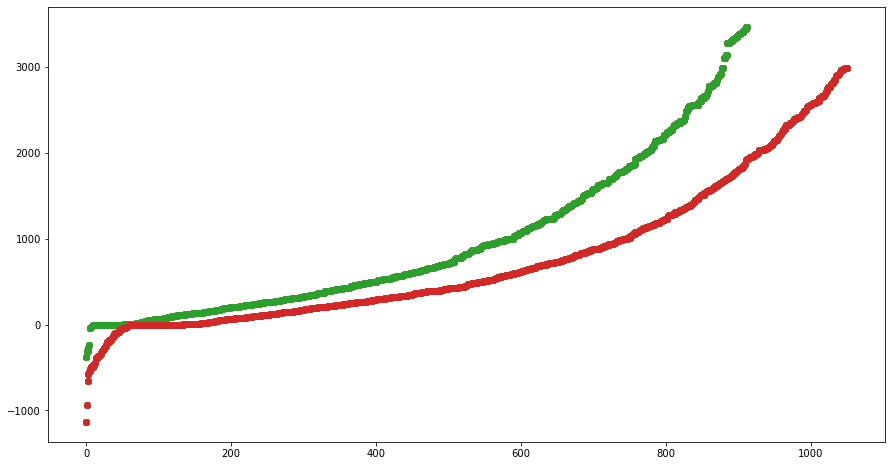

In [48]:
plt.figure(figsize=(15,8))

for label in data_classification.Label:
    data_case = data_classification[data_classification.Label == label]
    x = range(data_case.shape[0])
    y = data_case.Balance
    plt.scatter(x=x,y=y)

plt.show()

In [49]:
data_classification

,Balance,Label
1059,-382,Success
157,-309,Success
148,-306,Success
51,-271,Success
67,-242,Success
...,...,...
444,2979,Failure
303,2986,Failure
596,2987,Failure
337,2987,Failure


## Logistic Regression

In [50]:
# Implement model

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_classification.Balance, data_classification.Label, test_size=0.2, random_state=0)

X_train=X_train.to_numpy().reshape(-1,1)
X_test=X_test.to_numpy().reshape(-1,1)


In [51]:
lr = LogisticRegression(penalty='none',max_iter=100)

lr.fit(X=X_train, y=y_train)

lr_error_rate = (1-lr.score(X_train,y_train))*100

print("Logistic regression error rate using balance feature is {}%".format(np.round(lr_error_rate,2)))

#predictedLogist = logisticRegression.predict(X_test)

#predictedLogist.

Logistic regression error rate using balance feature is 44.43%


In [52]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [59]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)*100))

Accuracy of logistic regression classifier on test set: 51.65


In [60]:
cm = confusion_matrix(y_test, predictedLogist)

cm[0][1]
cm

array([[161,  47],
       [143,  42]], dtype=int64)

In [61]:
print(classification_report(y_test,predictedLogist))

              precision    recall  f1-score   support

     Failure       0.53      0.77      0.63       208
     Success       0.47      0.23      0.31       185

    accuracy                           0.52       393
   macro avg       0.50      0.50      0.47       393
weighted avg       0.50      0.52      0.48       393



# Let's integrate more variables so that a deeper analysis can be made

In [98]:
# depend on the balance, deposit, or loan

sql_query_final = '''
SELECT balance, deposit, loan, poutcome FROM bank
WHERE poutcome = 'failure' OR poutcome = 'success'
'''

cursor.execute(sql_query_final)

ml_data = cursor.fetchall()

In [100]:
ml_data = pd.DataFrame(ml_data, columns=['Balance', 'Deposit', 'Loan', 'Outcome'])

In [101]:
ml_data = pd.get_dummies(ml_data, drop_first=True)
ml_data.columns = ['Balance', 'Deposit', 'Loan', 'Outcome']
ml_data

,Balance,Deposit,Loan,Outcome
0,3444,1,0,0
1,589,1,0,1
2,899,1,0,0
3,2269,1,0,1
4,5115,1,0,0
...,...,...,...,...
2294,21,0,0,0
2295,1594,0,0,0
2296,-134,0,0,0
2297,80,0,1,0


In [110]:
# Apply all the filters to eliminate outliers


ml_data = ml_data[((ml_data.Balance <= 3500) & (ml_data.Outcome == 1)) | ((ml_data.Balance<=3000) & (ml_data.Outcome == 0))]

In [114]:
# Which features will we be using?
features = ['Balance', 'Deposit', 'Loan']

In [112]:
# Let's use KNN for the analysis

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

In [119]:
# We will implement up to 16 nearet neighbours in our analysis

#train_error = []

#test_error = []

knn_many_split = {}

erro_df_knn = pd.DataFrame()

for k in range(1,16):
    
    train_error = []
    test_error = []
    lista = []
    knn = KNeighborsClassifier(n_neighbors=k)
    print('Number of neigbours is', k)
        
    for i in range(100):
        x_train, x_test, y_train, y_test = train_test_split(ml_data[features], ml_data['Outcome'], test_size=0.2)
        
        x_train = ss.fit_transform(x_train)
        x_test = ss.transform(x_test)
        
        # Fitting the knn model
        knn.fit(x_train, y_train)
        
        train_error.append(1 - knn.score(x_train,y_train))
        test_error.append(1-knn.score(x_test,y_test))

        
    lista.append(sum(train_error)/len(train_error))
    lista.append(sum(test_error)/len(test_error))
    
    knn_many_split[k] = lista
    print(knn_many_split[k])

knn_many_split

Number of neigbours is 1
[0.11160407383831952, 0.358498727735369]
Number of neigbours is 2
[0.1980458306810948, 0.36867684478371493]
Number of neigbours is 3
[0.19595162316995549, 0.3358778625954201]
Number of neigbours is 4
[0.22662635264162959, 0.3555470737913485]
Number of neigbours is 5
[0.23429662635264165, 0.33671755725190833]
Number of neigbours is 6
[0.2520942075111394, 0.34628498727735374]
Number of neigbours is 7
[0.2524379376193507, 0.3224681933842239]
Number of neigbours is 8
[0.2607893061744112, 0.33582697201017825]
Number of neigbours is 9
[0.2611648631444939, 0.3170483460559797]
Number of neigbours is 10
[0.2678612348822407, 0.327379134860051]
Number of neigbours is 11
[0.26811584977721203, 0.31480916030534345]
Number of neigbours is 12
[0.2734882240611076, 0.32206106870229]
Number of neigbours is 13
[0.27534054742202413, 0.31450381679389305]
Number of neigbours is 14
[0.2795480585614257, 0.32605597964376587]
Number of neigbours is 15
[0.27914704010184593, 0.311908396946

{1: [0.11160407383831952, 0.358498727735369],
 2: [0.1980458306810948, 0.36867684478371493],
 3: [0.19595162316995549, 0.3358778625954201],
 4: [0.22662635264162959, 0.3555470737913485],
 5: [0.23429662635264165, 0.33671755725190833],
 6: [0.2520942075111394, 0.34628498727735374],
 7: [0.2524379376193507, 0.3224681933842239],
 8: [0.2607893061744112, 0.33582697201017825],
 9: [0.2611648631444939, 0.3170483460559797],
 10: [0.2678612348822407, 0.327379134860051],
 11: [0.26811584977721203, 0.31480916030534345],
 12: [0.2734882240611076, 0.32206106870229],
 13: [0.27534054742202413, 0.31450381679389305],
 14: [0.2795480585614257, 0.32605597964376587],
 15: [0.27914704010184593, 0.311908396946565]}

In [127]:
# Let's plot the training and test error to see the differences

kl = []
vl = []
v2 = []

for k,v in knn_many_split.items():
    
    kl.append(k)
    
    vl.append(knn_many_split[k][1])
    
    v2.append(knn_many_split[k][0])


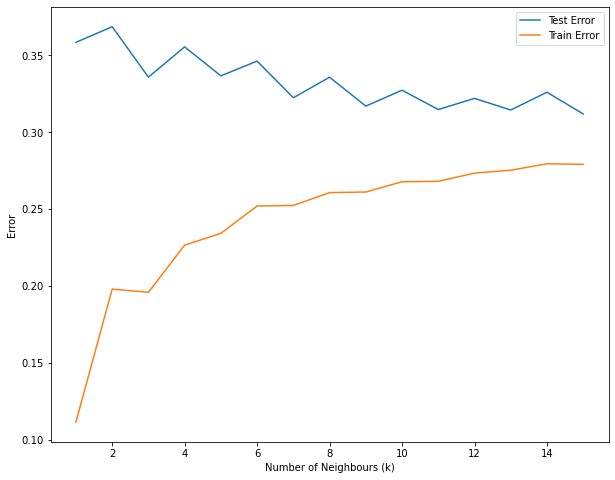

In [129]:
# Let's plot the differences between both types of errors

plt.figure(figsize = (10,8))

plt.xlabel('Number of Neighbours (k)')

plt.ylabel('Error')

plt.plot(kl,vl, label = 'Test Error')

plt.plot(kl,v2, label = 'Train Error')

plt.legend()

plt.show()

## Results knn

As we can see from the below graph, the error in the test and train data tends to a value somewhere near 0.28. Eventhough it increased, as opposed from the Logistic Regression model, it still has much room for improvement. It is now clear that various ML models can end up yielding different results. 

* The accuracy improved

#  Decision Tree

In [155]:
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

# Let's provide the model with class weights so that it does not become biased towards a dominant value
x_train, x_test, y_train, y_test = train_test_split(ml_data[features], ml_data['Outcome'], test_size=0.2)
y_train.value_counts()

0    841
1    730
Name: Outcome, dtype: int64

In [157]:
weight_failure = y_train.value_counts()[0]/y_train.count()
weight_success = y_train.value_counts()[1]/y_train.count()

In [158]:
dt = DecisionTreeClassifier(class_weight={0:weight_failure, 1:weight_success}, random_state=1)
dt.fit(x_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.5353278166772756,
                                     1: 0.46467218332272436},
                       random_state=1)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       841
           1       0.91      0.87      0.89       730

    accuracy                           0.90      1571
   macro avg       0.90      0.90      0.90      1571
weighted avg       0.90      0.90      0.90      1571



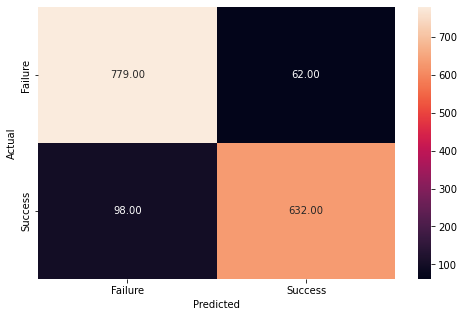

In [159]:
# Let's now check the model's performance

y_train_pred_dt = dt.predict(x_train)


print(classification_report(y_train, y_train_pred_dt))

cm = confusion_matrix(y_train, y_train_pred_dt)

plt.figure(figsize=(8,5))

sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Failure', 'Success'], yticklabels = ['Failure', 'Success'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()


### Train set

The decision tree model for the training set yield 90% overall accuracy. Let's test it with the test dataset

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       210
           1       0.62      0.61      0.62       183

    accuracy                           0.64       393
   macro avg       0.64      0.64      0.64       393
weighted avg       0.64      0.64      0.64       393



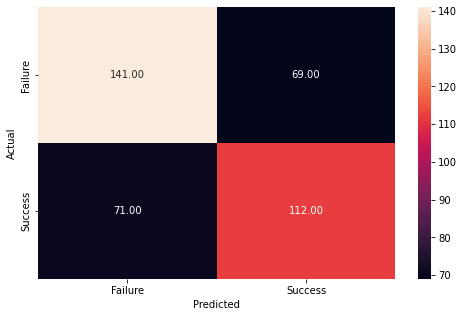

In [160]:
y_test_predict_dt = dt.predict(x_test)

print(classification_report(y_test, y_test_predict_dt))

cm = confusion_matrix(y_test, y_test_predict_dt)

plt.figure(figsize=(8,5))

sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Failure', 'Success'], yticklabels = ['Failure', 'Success'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

## Test dataset

Here for the test dataset the accuracy was 64% which is approximately 8% lower than in the KNN method.

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Importance'>

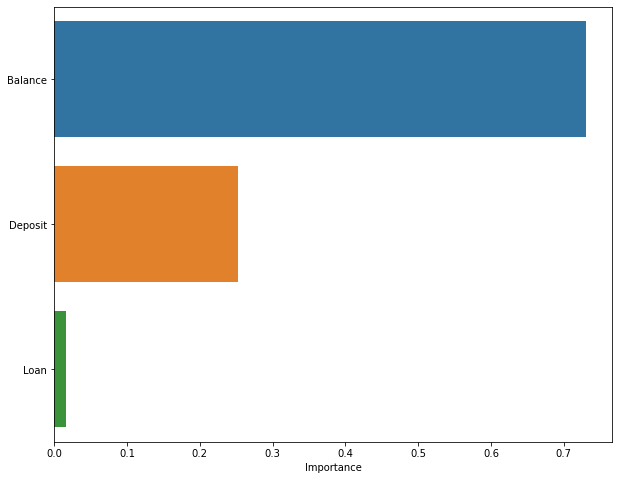

In [163]:
# Let's see the relevance of each variable

importances = dt.feature_importances_

columns =  ml_data.drop(['Outcome'] , axis = 1).columns

importance_df = pd.DataFrame(importances, index = columns, columns= ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize=(10,8))

sns.barplot(importance_df.Importance, importance_df.index)


# Final conclusions

As it could be seen, there is a relation between the success of the marketing campaign of the bank and whether or not the users were given a loan, whether they have deposits and the balance on their accounts. Various Machine Learning models were implemented to test this out using tools such as SQL, Pandas, Pythons and statistic libraries within this programming language, Further analysis can be done to obtain a suitable prediction that satisfies the task at hand, however with this a relationship is proved to exist.

As a initial analysis of the hypothesis of this last problem hyphothesis, this work served its objective. The models were not accurate enough (setting 85% as a 'good' threshold) when predicting the outcome of the campaign, but accomplished the objective of identifying the importance of each of the analysed variables.